# Heart Disease Prediction

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from IPython.display import display
import itertools
from sklearn.metrics import precision_recall_curve,average_precision_score, accuracy_score,roc_curve,roc_auc_score,confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler

## Importing The Heart Disease Data Set

In [118]:
pd.set_option('mode.chained_assignment', None)
data = pd.read_csv("Data/heart_2020_cleaned.csv")
df = pd.DataFrame(data)

## Exploring The Data Set

In [119]:
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  object 
 16  KidneyDisease     31

In [121]:
df.describe()

,BMI,PhysicalHealth,MentalHealth,SleepTime
count,319795.000000,319795.00000,319795.000000,319795.000000
mean,28.325399,3.37171,3.898366,7.097075
std,6.356100,7.95085,7.955235,1.436007
min,12.020000,0.00000,0.000000,1.000000
25%,24.030000,0.00000,0.000000,6.000000
50%,27.340000,0.00000,0.000000,7.000000
75%,31.420000,2.00000,3.000000,8.000000
max,94.850000,30.00000,30.000000,24.000000


In [122]:
df.describe(include='object')

,HeartDisease,Smoking,AlcoholDrinking,Stroke,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,Asthma,KidneyDisease,SkinCancer
count,319795,319795,319795,319795,319795,319795,319795,319795,319795,319795,319795,319795,319795,319795
unique,2,2,2,2,2,2,13,6,4,2,5,2,2,2
top,No,No,No,No,No,Female,65-69,White,No,Yes,Very good,No,No,No
freq,292422,187887,298018,307726,275385,167805,34151,245212,269653,247957,113858,276923,308016,289976


In [123]:
df.corr()

,BMI,PhysicalHealth,MentalHealth,SleepTime
BMI,1.000000,0.109788,0.064131,-0.051822
PhysicalHealth,0.109788,1.000000,0.287987,-0.061387
MentalHealth,0.064131,0.287987,1.000000,-0.119717
SleepTime,-0.051822,-0.061387,-0.119717,1.000000


In [124]:
l=df.shape[0]

## Assigning Heart Disease As The Target Variable

The visualisation of heart disease in the data set will be represented as a percentage.

In [125]:
df['HeartDisease'].value_counts()/l*100

No     91.440454
Yes     8.559546
Name: HeartDisease, dtype: float64

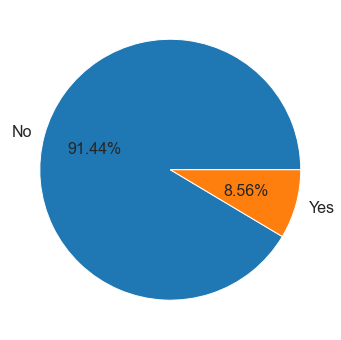

In [126]:
fig,ax = plt.subplots(figsize=(10,6))
labels = df['HeartDisease'].unique()
ax.pie(df['HeartDisease'].value_counts(),labels=labels,autopct='%1.2f%%',textprops={'fontsize':16})
plt.show()

As we can see, 8.56% of the data set is associated with heart disease.

## Features

In [127]:
dummy_df = df.copy()

In [128]:
dummy_df.loc[dummy_df['HeartDisease'] == 'Yes','HeartDisease'] = 1
dummy_df.loc[dummy_df['HeartDisease'] == 'No','HeartDisease'] = 0

### Body Mass Index (BMI)

In [129]:
df['BMI'].describe()

count    319795.000000
mean         28.325399
std           6.356100
min          12.020000
25%          24.030000
50%          27.340000
75%          31.420000
max          94.850000
Name: BMI, dtype: float64

<AxesSubplot:xlabel='BMI'>

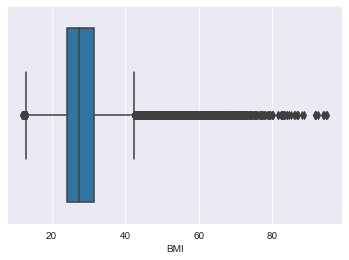

In [130]:
sns.boxplot(data=df, x='BMI')

BMI has a lot of spread, so we will make it a categorical variable based on the industry's specifications.
This is done with the categories of "Underweight", "Normal", "Overweight", "Obese", and "Extremely Obese".

In [131]:
t=df['BMI']
cond = [(t.between(0,18.5)),(t.between(18.5,24.9)),(t.between(24.9,29.9)),(t.between(29.9,34.9)),(t.between(34.9,100))]
labels = ['Underweight','Normal','Overweight','Obese','Extremely Obese']
df['BMI_cat'] = np.select(cond,labels)

In [132]:
df.drop(columns=['BMI'],inplace=True)

In [133]:
df['BMI_cat'].value_counts()

Overweight         114752
Normal              95134
Obese               62172
Extremely Obese     42623
Underweight          5114
Name: BMI_cat, dtype: int64

We have more people with a BMI of overweight than underweight, which matches the average BMI of the U.S. population.

In [134]:
dummy_df['BMI_cat']=df['BMI_cat']
t1=dummy_df[['HeartDisease','BMI_cat']].groupby(['BMI_cat'],as_index=False).mean()

<AxesSubplot:xlabel='BMI_cat', ylabel='HeartDisease'>

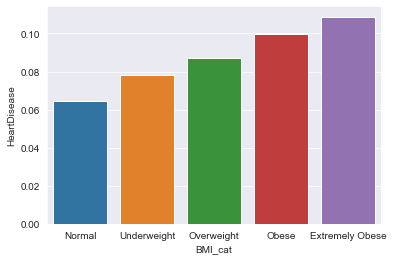

In [135]:
sns.barplot(data=t1.sort_values(by='HeartDisease'),x='BMI_cat',y='HeartDisease')

We are shown above that extremely obese people have a higher risk of heart disease than underweight and normal weight people.

### Physical Health

In [136]:
df['PhysicalHealth'].describe()

count    319795.00000
mean          3.37171
std           7.95085
min           0.00000
25%           0.00000
50%           0.00000
75%           2.00000
max          30.00000
Name: PhysicalHealth, dtype: float64

<AxesSubplot:xlabel='PhysicalHealth'>

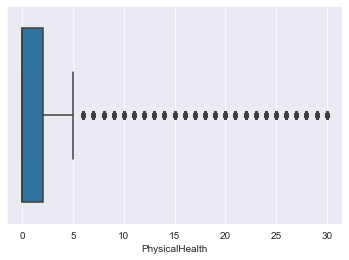

In [137]:
sns.boxplot(data=df, x='PhysicalHealth')

<AxesSubplot:xlabel='PhysicalHealth', ylabel='Density'>

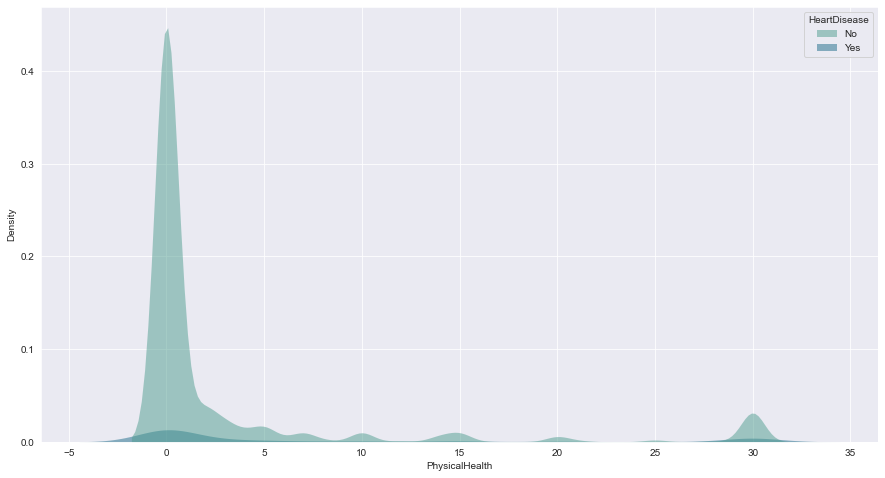

In [138]:
fig, ax = plt.subplots(figsize = (15, 8))
sns.kdeplot(data=df, x='PhysicalHealth', hue='HeartDisease', fill=True, palette='crest', alpha=.5, linewidth=0)

Above, we have the plots [P(X|Y=No) and P(X|Y=Yes)P(Y=Yes), where X is the PhysicalHealth], where they take into account the prior probability of each class (P(Y=No) and P(Y=Yes) respectively).

Thus, due to the fact that the data set is not balanced, we can't use the naïve Bayes model.

We now need to look at the probability independently for the different classes.
(P(X|Y=No) and P(X|Y=Yes))

This means we do not take into account the prior probability of each class, in order to better understand the effect of X on the classes.

<AxesSubplot:xlabel='PhysicalHealth', ylabel='Density'>

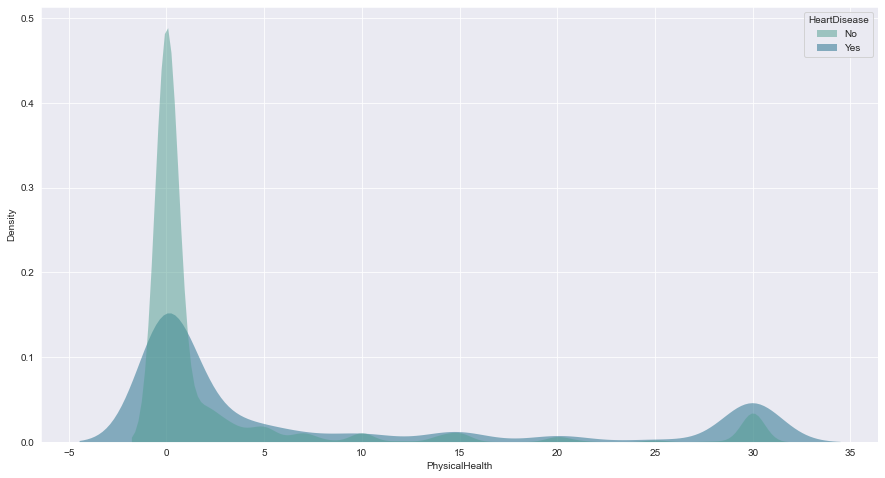

In [139]:

fig, ax = plt.subplots(figsize = (15, 8))
sns.kdeplot(data=df, x='PhysicalHealth', hue='HeartDisease', fill=True, common_norm=False, palette='crest', alpha=.5, linewidth=0)

Above, we can see that the probability for people with heart disease being healthy for the prior 30 days (X=0) is lower than the people with no heart disease.

On the inverse, the probability is higher for people who have been ill for the prior 30 days.

<AxesSubplot:xlabel='HeartDisease', ylabel='PhysicalHealth'>

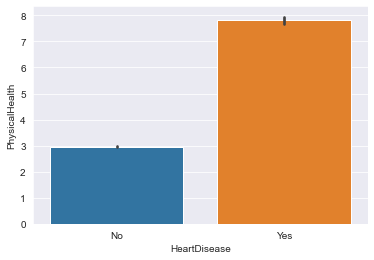

In [140]:
sns.barplot(y='PhysicalHealth',data=df,x='HeartDisease')

The average amount of sick days, over the course of 30 days, are significantly higher for those with heart disease.

### Mental Health

In [141]:
df['MentalHealth'].describe()

count    319795.000000
mean          3.898366
std           7.955235
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          30.000000
Name: MentalHealth, dtype: float64

<AxesSubplot:xlabel='MentalHealth'>

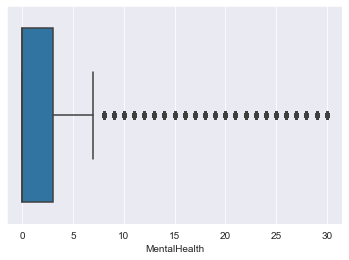

In [142]:
sns.boxplot(data=df, x='MentalHealth')

<AxesSubplot:xlabel='MentalHealth', ylabel='Density'>

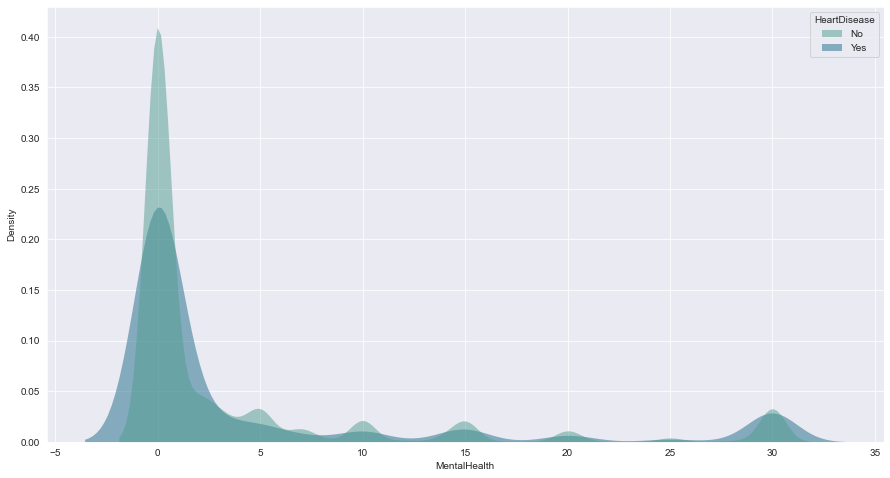

In [143]:
fig, ax = plt.subplots(figsize = (15, 8))
sns.kdeplot(data=df, x='MentalHealth', hue='HeartDisease', fill=True, common_norm=False, palette='crest', alpha=.5, linewidth=0)

Above, we can see that mental health is not a good predictor of heart disease.

The probability for someone with bad mental health having heart disease is around the same, or even sometimes lower than the people with bad mental health not having heart disease.

<AxesSubplot:xlabel='HeartDisease', ylabel='MentalHealth'>

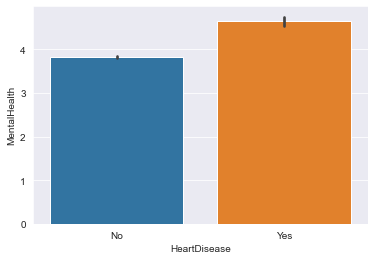

In [144]:
sns.barplot(y='MentalHealth',data=df,x='HeartDisease')

The difference in average days for bad mental health is also around the same for both cases, which could mean that mental health is not a good predictor of heart disease.

We will drop the mental health column from the data set.

In [145]:
df.drop(columns='MentalHealth', inplace=True)

### Sleep

In [146]:
df['SleepTime'].describe()

count    319795.000000
mean          7.097075
std           1.436007
min           1.000000
25%           6.000000
50%           7.000000
75%           8.000000
max          24.000000
Name: SleepTime, dtype: float64

The maximum amount of sleep time is 24 hours, while the median value is around 7 hours.

In [147]:
df['SleepTime'].value_counts()

7.0     97751
8.0     97602
6.0     66721
5.0     19184
9.0     16041
10.0     7796
4.0      7750
12.0     2205
3.0      1992
2.0       788
1.0       551
11.0      415
14.0      243
16.0      236
15.0      189
18.0      102
13.0       97
20.0       64
24.0       30
17.0       21
22.0        9
19.0        3
23.0        3
21.0        2
Name: SleepTime, dtype: int64

<AxesSubplot:xlabel='SleepTime'>

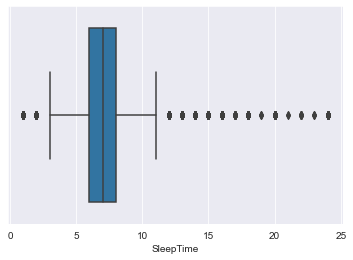

In [148]:
sns.boxplot(data=df, x='SleepTime')

<AxesSubplot:xlabel='SleepTime', ylabel='Density'>

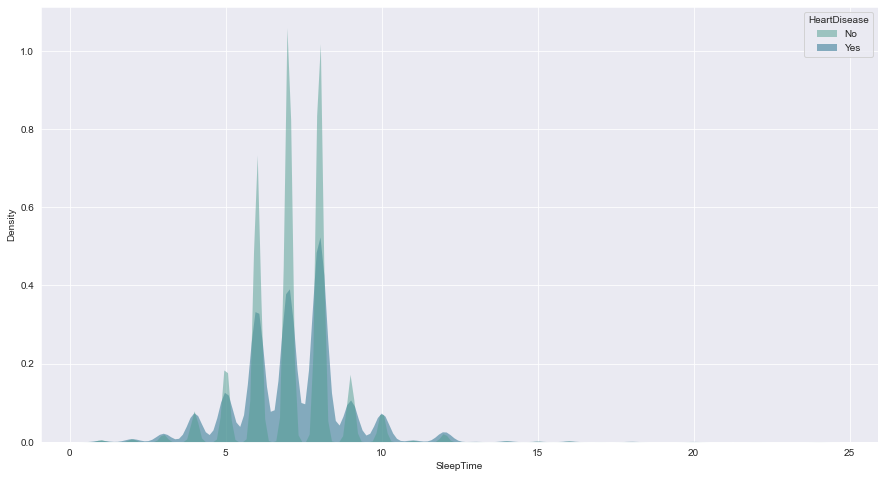

In [149]:
fig, ax = plt.subplots(figsize = (15, 8))
sns.kdeplot(data=df, x='SleepTime', hue='HeartDisease', fill=True, common_norm=False, palette='crest', alpha=.5, linewidth=0)

In [150]:
t2=dummy_df[["HeartDisease","SleepTime"]].groupby(['SleepTime'],as_index=False).mean()

<AxesSubplot:xlabel='SleepTime', ylabel='HeartDisease'>

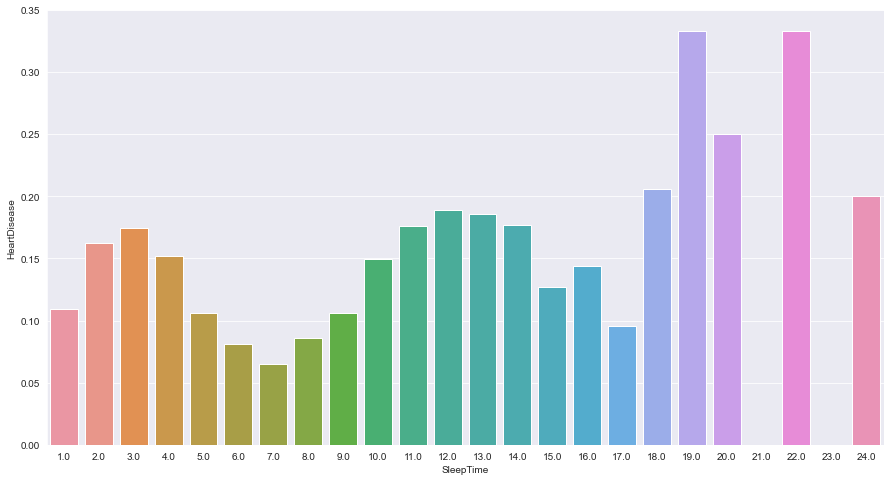

In [151]:
fig, ax = plt.subplots(figsize = (15, 8))
sns.barplot(data=t2.sort_values(by='HeartDisease'),x='SleepTime',y='HeartDisease')

From the above plots, we can see that people who sleep less than 7 hours, and also those who sleep more than 7 hours, have a higher risk of heart disease.

Considering the spread of the data, the outliers, and its trend when compared to the target, we will drop the SleepTime column from the data set.

In [152]:
st=df['SleepTime']
cond = [(st.between(0, 6)),(st.between(6,9)),(st.between(9,24))]
labels = ['Low', 'Normal', 'High']
df['SleepTime_cat'] = np.select(cond, labels)

In [153]:
df.drop(columns=['SleepTime'],inplace=True)

In [154]:
df['SleepTime_cat'].value_counts()

Normal    211394
Low        96986
High       11415
Name: SleepTime_cat, dtype: int64

In [155]:
dummy_df['SleepTime_cat']=df['SleepTime_cat']

In [156]:
t3=dummy_df[['HeartDisease','SleepTime_cat']].groupby(['SleepTime_cat'],as_index=False).mean()

<AxesSubplot:xlabel='SleepTime_cat', ylabel='HeartDisease'>

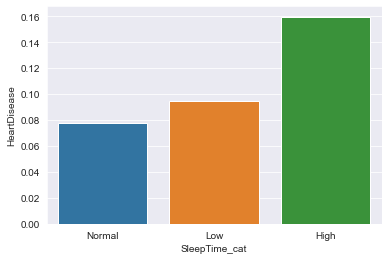

In [157]:
sns.barplot(data=t3.sort_values(by='HeartDisease'),x='SleepTime_cat',y='HeartDisease')

### Smoking

In [158]:
df['Smoking'].value_counts()

No     187887
Yes    131908
Name: Smoking, dtype: int64

In [159]:
t4=dummy_df[['HeartDisease','Smoking']].groupby(['Smoking'],as_index=False).mean()

<AxesSubplot:xlabel='Smoking', ylabel='HeartDisease'>

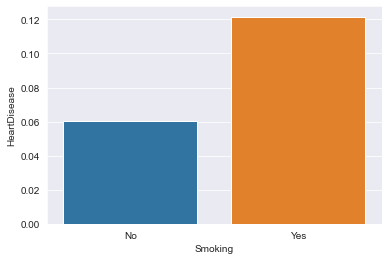

In [160]:
sns.barplot(data=t4.sort_values(by='HeartDisease'),x='Smoking',y='HeartDisease')

Smoking is a good predictor of heart disease.

### Alcohol

In [161]:
df['AlcoholDrinking'].value_counts()/l*100

No     93.190325
Yes     6.809675
Name: AlcoholDrinking, dtype: float64

In [162]:
t5=dummy_df[["HeartDisease","AlcoholDrinking"]].groupby(['AlcoholDrinking'],as_index=False).mean()

<AxesSubplot:xlabel='AlcoholDrinking', ylabel='HeartDisease'>

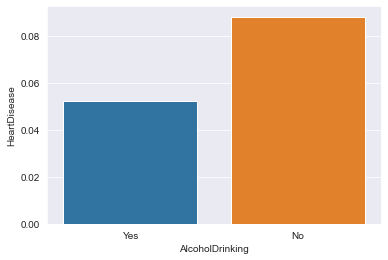

In [163]:
sns.barplot(data=t5.sort_values(by='HeartDisease'),x='AlcoholDrinking',y='HeartDisease')

Due to the fact that only 6.8% of the data set are heavy drinkers, we can drop the AlcoholDrinking column from the data set.

In [164]:
df[df['AlcoholDrinking'] == 'Yes']['HeartDisease'].value_counts()

No     20636
Yes     1141
Name: HeartDisease, dtype: int64

In [165]:
df['HeartDisease'].value_counts()

No     292422
Yes     27373
Name: HeartDisease, dtype: int64

In [166]:
df.drop(columns='AlcoholDrinking', inplace=True)

### Stroke

In [167]:
df['Stroke'].value_counts()/l*100

No     96.22602
Yes     3.77398
Name: Stroke, dtype: float64

In [168]:
t6=dummy_df[['HeartDisease','Stroke']].groupby(['Stroke'],as_index=False).mean()

<AxesSubplot:xlabel='Stroke', ylabel='HeartDisease'>

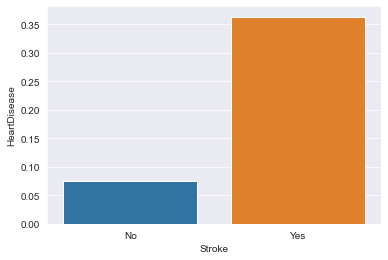

In [169]:
sns.barplot(data=t6.sort_values(by='HeartDisease'),x='Stroke',y='HeartDisease')

People with a past history of a stroke could be much more likely to have heart disease.

### Difficulty Walking

In [170]:
df['DiffWalking'].value_counts()/l*100

No     86.112979
Yes    13.887021
Name: DiffWalking, dtype: float64

In [171]:
t7=dummy_df[['HeartDisease','DiffWalking']].groupby(['DiffWalking'],as_index=False).mean()

<AxesSubplot:xlabel='DiffWalking', ylabel='HeartDisease'>

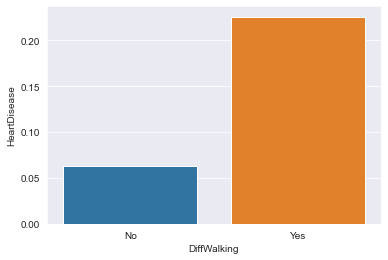

In [172]:
sns.barplot(data=t7.sort_values(by='HeartDisease'),x='DiffWalking',y='HeartDisease')

Difficulty walking is a good indicator of heart disease.

### Sex

In [173]:
df['Sex'].value_counts()/l*100

Female    52.472678
Male      47.527322
Name: Sex, dtype: float64

In [174]:
t8=dummy_df[['HeartDisease','Sex']].groupby(['Sex'],as_index=False).mean()

<AxesSubplot:xlabel='Sex', ylabel='HeartDisease'>

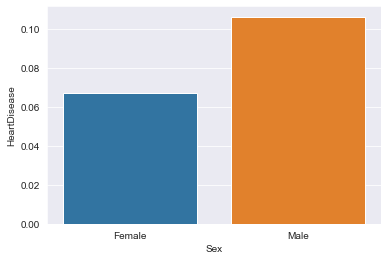

In [175]:
sns.barplot(data=t8.sort_values(by='HeartDisease'),x='Sex',y='HeartDisease')

Males seem to be more likely to have heart disease than females.

### Age

In [176]:
df['AgeCategory'].value_counts()/l*100

65-69          10.679029
60-64          10.533623
70-74           9.714036
55-59           9.305024
50-54           7.936960
80 or older     7.552651
45-49           6.814053
75-79           6.717428
18-24           6.586720
40-44           6.568583
35-39           6.425992
30-34           5.864069
25-29           5.301834
Name: AgeCategory, dtype: float64

In [177]:
t9=dummy_df[['HeartDisease', 'AgeCategory']].groupby(['AgeCategory'], as_index=False).mean()

<AxesSubplot:xlabel='AgeCategory', ylabel='HeartDisease'>

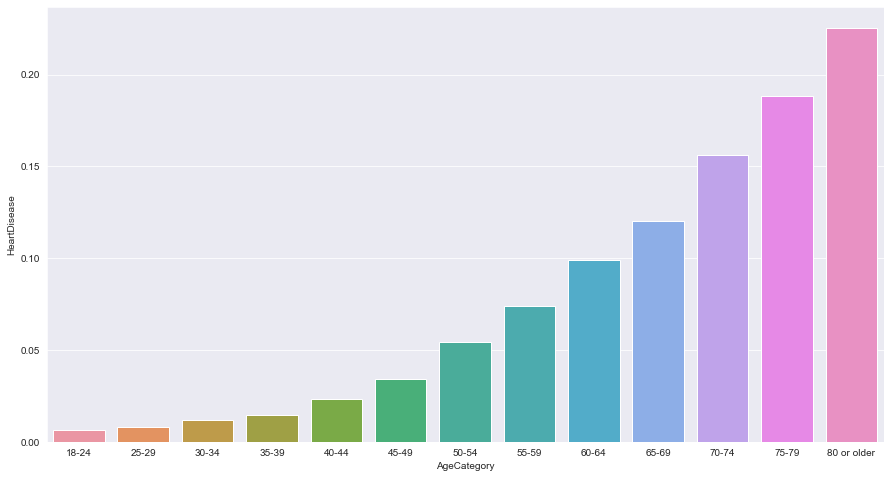

In [178]:
fig, ax = plt.subplots(figsize = (15, 8))
sns.barplot(data=t9.sort_values(by='HeartDisease'),x='AgeCategory',y='HeartDisease')

The risk of heart disease seems to increase as a person gets older.

We will replace the AgeCategory column with the mean value for each range.
We will also do encoding for the categorical data.

In [179]:
AgeCategory_mean = {'18-24':21, '25-29':27, '30-34':32, '35-39':37, '40-44':42, '45-49':47, '50-54':52, '55-59':57, '60-64':62, '65-69':67, '70-74':72, '75-79':77, '80 or older':80}
df['Mean_Age'] = df['AgeCategory'].apply(lambda x: AgeCategory_mean[x])

In [180]:
df.drop(columns=['AgeCategory'],inplace=True)

### Race

In [181]:
df['Race'].value_counts()/l*100

White                             76.677872
Hispanic                           8.582373
Black                              7.173033
Other                              3.417189
Asian                              2.522866
American Indian/Alaskan Native     1.626667
Name: Race, dtype: float64

In [182]:
t10 = dummy_df[['HeartDisease', 'Race']].groupby(['Race'],as_index=False).mean()

<AxesSubplot:xlabel='Race', ylabel='HeartDisease'>

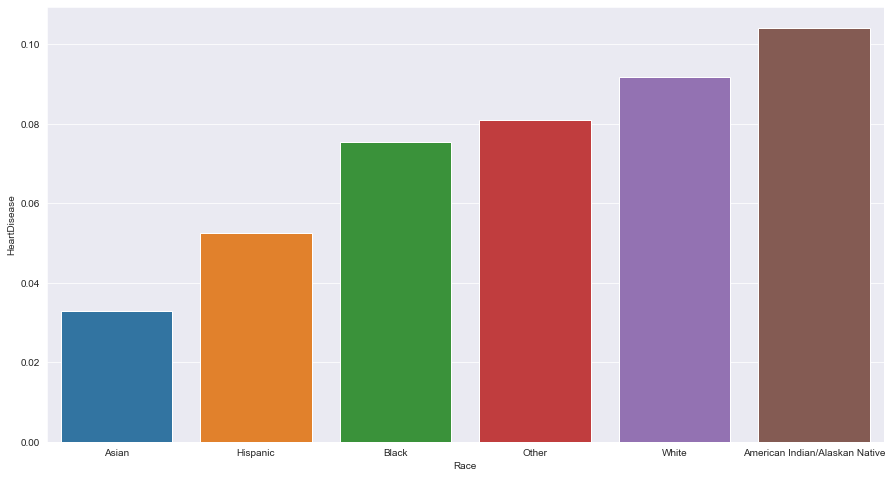

In [183]:
fig, ax = plt.subplots(figsize = (15, 8))
sns.barplot(data=t10.sort_values(by='HeartDisease'), x='Race', y='HeartDisease')

Given the plot above, Native Americans seem to be at a higher risk of heart disease, which is in line with reports by the CDC.

The reports also show that heart disease is the leading cause of death among Native Americans.

Asians seem to have the lowest risk of heart disease.

### Diabetes

In [184]:
df['Diabetic'].value_counts()/l*100

No                         84.320580
Yes                        12.758799
No, borderline diabetes     2.120421
Yes (during pregnancy)      0.800200
Name: Diabetic, dtype: float64

In [185]:
t11=dummy_df[['HeartDisease','Diabetic']].groupby(['Diabetic'], as_index=False).mean()

<AxesSubplot:xlabel='Diabetic', ylabel='HeartDisease'>

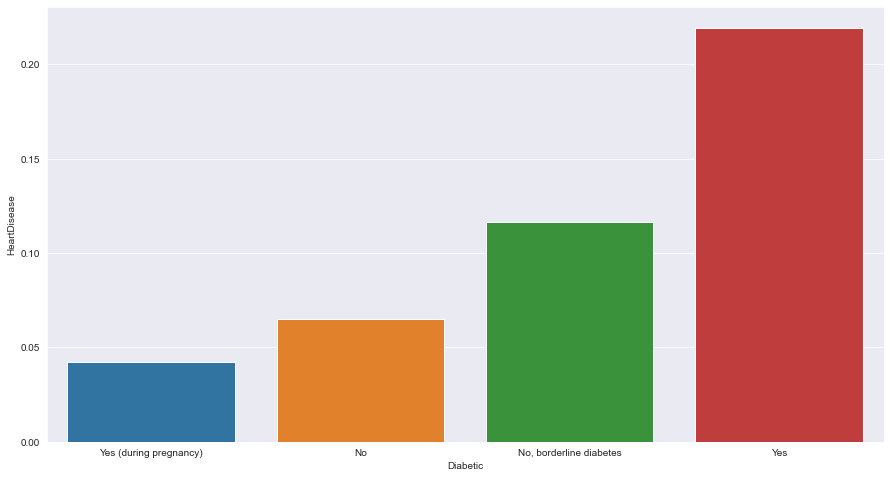

In [186]:
fig, ax = plt.subplots(figsize = (15, 8))
sns.barplot(data=t11.sort_values(by='HeartDisease'),x='Diabetic',y='HeartDisease')

People with Diabetes are at a higher risk of heart disease.

### Kidney Disease

In [187]:
df['KidneyDisease'].value_counts()/l*100

No     96.316703
Yes     3.683297
Name: KidneyDisease, dtype: float64

In [188]:
t12=dummy_df[['HeartDisease','KidneyDisease']].groupby(['KidneyDisease'], as_index=False).mean()

<AxesSubplot:xlabel='KidneyDisease', ylabel='HeartDisease'>

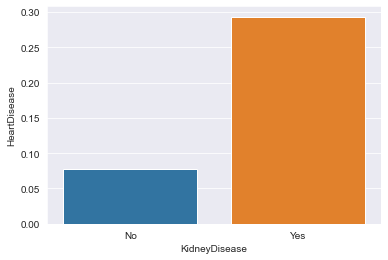

In [189]:
sns.barplot(data=t12.sort_values(by='HeartDisease'),x='KidneyDisease',y='HeartDisease')

People with a history of kidney disease are at a higher risk of heart disease.

### Skin Cancer

In [190]:
df['SkinCancer'].value_counts()/l*100

No     90.675589
Yes     9.324411
Name: SkinCancer, dtype: float64

In [191]:
t13 = dummy_df[['HeartDisease', 'SkinCancer']].groupby(['SkinCancer'],as_index=False).mean()

<AxesSubplot:xlabel='SkinCancer', ylabel='HeartDisease'>

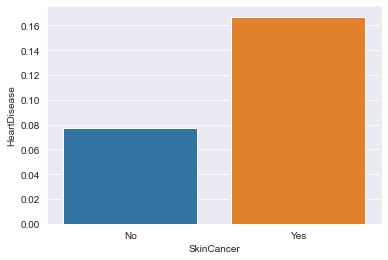

In [192]:
sns.barplot(data=t13.sort_values(by='HeartDisease'),x='SkinCancer',y='HeartDisease')

People with a history of skin cancer are at a higher risk of heart disease.

### Asthma

In [193]:
df['Asthma'].value_counts()/l*100

No     86.593912
Yes    13.406088
Name: Asthma, dtype: float64

In [194]:
t14=dummy_df[['HeartDisease','Asthma']].groupby(['Asthma'], as_index=False).mean()

<AxesSubplot:xlabel='Asthma', ylabel='HeartDisease'>

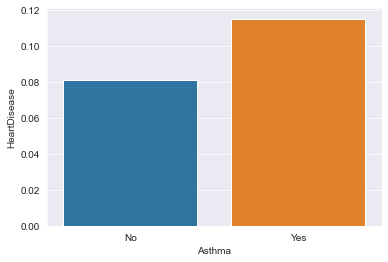

In [195]:
sns.barplot(data=t14.sort_values(by='HeartDisease'),x='Asthma',y='HeartDisease')

People with a history of asthma are at a somewhat higher risk of heart disease.

### Physical Activity

In [196]:
df['PhysicalActivity'].value_counts()/l*100

Yes    77.536234
No     22.463766
Name: PhysicalActivity, dtype: float64

In [197]:
t15=dummy_df[['HeartDisease','PhysicalActivity']].groupby(['PhysicalActivity'], as_index=False).mean()

<AxesSubplot:xlabel='PhysicalActivity', ylabel='HeartDisease'>

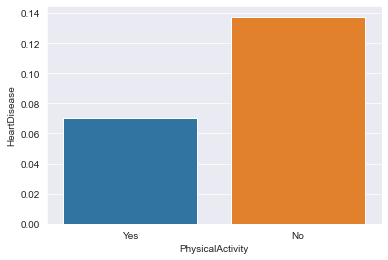

In [198]:
sns.barplot(data=t15.sort_values(by='HeartDisease'),x='PhysicalActivity',y='HeartDisease')

The plot above might indicate that physical activity can reduce the risk of heart disease.

### General Health

In [199]:
df['GenHealth'].value_counts()/l*100

Very good    35.603433
Good         29.121468
Excellent    20.901515
Fair         10.843509
Poor          3.530074
Name: GenHealth, dtype: float64

In [200]:
t16=dummy_df[['HeartDisease','GenHealth']].groupby(['GenHealth'], as_index=False).mean()

<AxesSubplot:xlabel='GenHealth', ylabel='HeartDisease'>

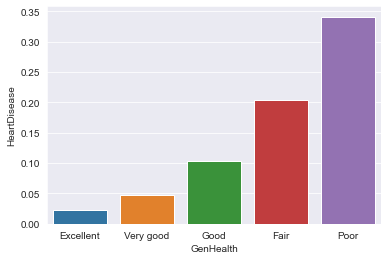

In [201]:
sns.barplot(data=t16.sort_values(by='HeartDisease'),x='GenHealth',y='HeartDisease')

The worse a person's general health is, the higher they might be at risk of heart disease.

# Model Building

### Encoding

In [202]:
df

,HeartDisease,Smoking,Stroke,PhysicalHealth,DiffWalking,Sex,Race,Diabetic,PhysicalActivity,GenHealth,Asthma,KidneyDisease,SkinCancer,BMI_cat,SleepTime_cat,Mean_Age
0,No,Yes,No,3.0,No,Female,White,Yes,Yes,Very good,Yes,No,Yes,Underweight,Low,57
1,No,No,Yes,0.0,No,Female,White,No,Yes,Very good,No,No,No,Normal,Normal,80
2,No,Yes,No,20.0,No,Male,White,Yes,Yes,Fair,Yes,No,No,Overweight,Normal,67
3,No,No,No,0.0,No,Female,White,No,No,Good,No,No,Yes,Normal,Low,77
4,No,No,No,28.0,Yes,Female,White,No,Yes,Very good,No,No,No,Normal,Normal,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319790,Yes,Yes,No,7.0,Yes,Male,Hispanic,Yes,No,Fair,Yes,No,No,Overweight,Low,62
319791,No,Yes,No,0.0,No,Male,Hispanic,No,Yes,Very good,Yes,No,No,Overweight,Low,37
319792,No,No,No,0.0,No,Female,Hispanic,No,Yes,Good,No,No,No,Normal,Low,47
319793,No,No,No,0.0,No,Female,Hispanic,No,No,Good,No,No,No,Obese,High,27


In [203]:
encoded_df = df.copy()

Label Encoding

In [204]:
le = preprocessing.LabelEncoder()
cols=['HeartDisease', 'Smoking', 'Stroke', 'DiffWalking', 'Sex', 'PhysicalActivity', 'Asthma', 'KidneyDisease', 'SkinCancer']

In [205]:
for i in cols:
    encoded_df[i] = le.fit_transform(encoded_df[i])

Assign 0 to Poor, and 4 to Excellent

In [206]:
le_1=le.fit(encoded_df['GenHealth'])
le_1.classes_ = np.array(['Poor', 'Fair', 'Good', 'Very good', 'Excellent'])
encoded_df['GenHealth'] = le_1.transform(encoded_df['GenHealth'])

One Hot Encoding

In [207]:
encoded_df=pd.concat([encoded_df, pd.get_dummies(encoded_df['Race'], prefix='Race', drop_first=False)], axis=1)
encoded_df=pd.concat([encoded_df, pd.get_dummies(encoded_df['Diabetic'], prefix='Diabetic',drop_first=False)], axis=1)
encoded_df=pd.concat([encoded_df, pd.get_dummies(encoded_df['BMI_cat'], prefix='BMI', drop_first=False)], axis=1)
encoded_df=pd.concat([encoded_df, pd.get_dummies(encoded_df['SleepTime_cat'], prefix='SleepTime', drop_first=False)], axis=1)
encoded_df.drop(columns=['Race', 'Diabetic', 'BMI_cat', 'SleepTime_cat'], axis=1, inplace=True)

In [208]:
with pd.option_context('display.max_columns', 30):
    display(encoded_df)

,HeartDisease,Smoking,Stroke,PhysicalHealth,DiffWalking,Sex,PhysicalActivity,GenHealth,Asthma,KidneyDisease,SkinCancer,Mean_Age,Race_American Indian/Alaskan Native,Race_Asian,Race_Black,Race_Hispanic,Race_Other,Race_White,Diabetic_No,"Diabetic_No, borderline diabetes",Diabetic_Yes,Diabetic_Yes (during pregnancy),BMI_Extremely Obese,BMI_Normal,BMI_Obese,BMI_Overweight,BMI_Underweight,SleepTime_High,SleepTime_Low,SleepTime_Normal
0,0,1,0,3.0,0,0,1,3,1,0,1,57,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0
1,0,0,1,0.0,0,0,1,3,0,0,0,80,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1
2,0,1,0,20.0,0,1,1,1,1,0,0,67,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1
3,0,0,0,0.0,0,0,0,2,0,0,1,77,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0
4,0,0,0,28.0,1,0,1,3,0,0,0,42,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319790,1,1,0,7.0,1,1,0,1,1,0,0,62,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0
319791,0,1,0,0.0,0,1,1,3,1,0,0,37,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0
319792,0,0,0,0.0,0,0,1,2,0,0,0,47,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0
319793,0,0,0,0.0,0,0,0,2,0,0,0,27,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0


### Standardization

In [209]:
sc = StandardScaler()

In [210]:
x = encoded_df.drop(columns=['HeartDisease'], axis=1)
y = encoded_df['HeartDisease']

col = x.columns

In [211]:
encod_stand_df = sc.fit_transform(x)
es_df = pd.DataFrame(encod_stand_df, columns=col)

### Splitting Data

In [212]:
x_train, x_test, y_train, y_test = train_test_split(es_df, y, test_size = 0.2, random_state = 42)

### Creating Evaluation Metrics

Compute and plot the confusion matrix.

In [213]:
def plot_confusion_matrix(model,x_test,y_test,normalize=False):
    y_pred = model.predict(x_test)
    cm = confusion_matrix(y_test, y_pred)
    classes=["No", "Yes"]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=3)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Compute and plot the ROC curve and AUC.

In [214]:
def plot_roc(model,x_test,y_test,plot_threshold=False,t=0.5):
    y_pred_proba = model.predict_proba(x_test)[::,1]
    fpr, tpr, thresh = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    y_text_margin=0.05
    x_text_margin=0.2
    x_thresh, y_thresh = fpr[np.argmin(abs(thresh - t))], tpr[np.argmin(abs(thresh - t))]
    plt.plot(fpr, tpr,lw=2,label='ROC curve (AUC = %0.2f)' % auc,linestyle='-')
    plt.plot([0, 1], [0, 1],label="Random guess",color='red',lw=2, linestyle='--')
    if plot_threshold:
        plt.axhline(y=y_thresh,lw=2,color='black',linestyle=':')
        plt.axvline(x=x_thresh,lw=2,color='black',linestyle=':')
        if x_thresh > 0.5 and y_thresh > 0.5:
            plt.text(x=x_thresh - x_text_margin, y=y_thresh - y_text_margin,s='Threshold : {:.2f}'.format(t))
        elif x_thresh <= 0.5 and y_thresh <= 0.5:
            plt.text(x=x_thresh + x_text_margin, y=y_thresh + y_text_margin,s='Threshold : {:.2f}'.format(t))
        elif x_thresh <= 0.5 < y_thresh:
            plt.text(x=x_thresh + x_text_margin, y=y_thresh - y_text_margin,s='Threshold : {:.2f}'.format(t))
        elif x_thresh > 0.5 >= y_thresh:
            plt.text(x=x_thresh - x_text_margin, y=y_thresh + y_text_margin,s='Threshold : {:.2f}'.format(t))
        plt.plot(x_thresh, y_thresh, 'ro')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc=0)

Compute and plot the Precision-Recall curve.

In [215]:
def plot_prc(model,x_test,y_test):
    y_pred_proba = model.predict_proba(x_test)[::,1]
    prec, rec, thresh = precision_recall_curve(y_test,  y_pred_proba)
    auc_val = average_precision_score(y_test, y_pred_proba)
    rand = len(y_test[y_test==1]) / len(y_test)
    plt.plot([0, 1], [rand, rand],color='red', linestyle='--', label='Random')
    plt.plot(rec, prec, marker='.', label='PR curve (AUC = %0.2f)' % auc_val,linestyle='-',color='orange')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc=0)

## Model

### Random Forest

In [216]:
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(x_train,y_train)
y_pred = model_rf.predict(x_test)
print("Accuracy:",accuracy_score(y_test, y_pred))
print("\n\t\t\tClassification report\n",classification_report(y_test, y_pred))

Accuracy: 0.9045013211588674

			Classification report
               precision    recall  f1-score   support

           0       0.92      0.98      0.95     58367
           1       0.37      0.13      0.19      5592

    accuracy                           0.90     63959
   macro avg       0.65      0.55      0.57     63959
weighted avg       0.87      0.90      0.88     63959



Since the accuracy is low, we will try to improve it by using some other techniques.

Recall is preferred in this case, since its better at detecting heart disease at the cost of having more false positives, whereas Precision has a higher cost of false negatives.

It's better to tell a patient that they have heart disease when they don't, rather than to tell a patient that they don't have heart disease when they do.

In [217]:
model_rf = RandomForestClassifier(random_state=42)
model_rf.set_params(n_estimators=500, class_weight="balanced",max_depth=30,min_samples_split= 30,min_samples_leaf=24)
model_rf.fit(x_train,y_train)
y_pred = model_rf.predict(x_test)
print("Accuracy:",accuracy_score(y_test, y_pred))
print("\n\t\t\tClassification report\n",classification_report(y_test, y_pred))

Accuracy: 0.7436795447083288

			Classification report
               precision    recall  f1-score   support

           0       0.97      0.74      0.84     58367
           1       0.22      0.79      0.35      5592

    accuracy                           0.74     63959
   macro avg       0.60      0.76      0.59     63959
weighted avg       0.91      0.74      0.80     63959



We can see that we have good recall for the minority class.

In [218]:
print('Cross Validation Score: ', cross_val_score(model_rf,x_train,y_train,cv=10).mean())

Cross Validation Score:  0.7465915562038845


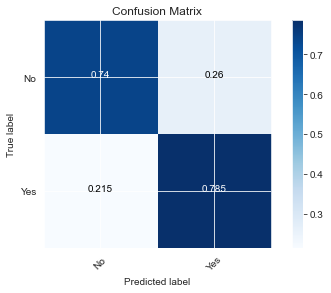

In [219]:
plot_confusion_matrix(model_rf, x_test, y_test, normalize=True)

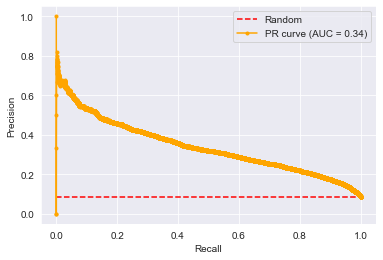

In [220]:
plot_prc(model_rf, x_test, y_test)

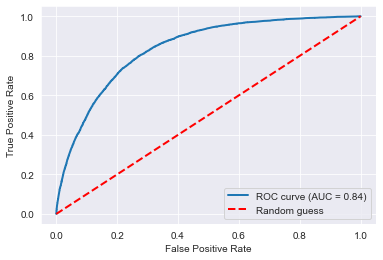

In [221]:
plot_roc(model_rf, x_test, y_test)

### Logistic Regression

In [222]:
model_lr = LogisticRegression(random_state=0, class_weight='balanced', max_iter=800)
model_lr.fit(x_train,y_train)
y_pred = model_lr.predict(x_test)
print("Accuracy:",accuracy_score(y_test, y_pred))
print("\n\t\t\tClassification report\n",classification_report(y_test, y_pred))

Accuracy: 0.7511530824434404

			Classification report
               precision    recall  f1-score   support

           0       0.97      0.75      0.85     58367
           1       0.23      0.78      0.35      5592

    accuracy                           0.75     63959
   macro avg       0.60      0.76      0.60     63959
weighted avg       0.91      0.75      0.80     63959



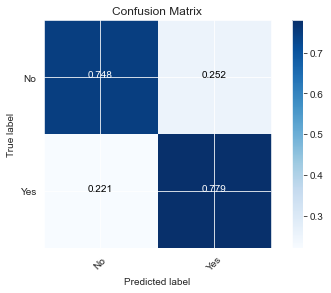

In [223]:
plot_confusion_matrix(model_lr, x_test, y_test, normalize=True)

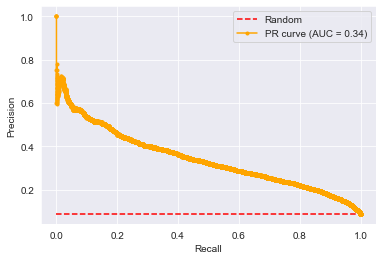

In [224]:
plot_prc(model_lr, x_test, y_test)

### Naive Bayes

In [225]:
model_nb = GaussianNB()
model_nb.fit(x_train,y_train)

y_pred = model_nb.predict(x_test)

print("Accuracy:",accuracy_score(y_test, y_pred))
print("\n\t\t\tClassification report\n",classification_report(y_test, y_pred))

Accuracy: 0.8052971434825436

			Classification report
               precision    recall  f1-score   support

           0       0.95      0.83      0.89     58367
           1       0.24      0.55      0.33      5592

    accuracy                           0.81     63959
   macro avg       0.59      0.69      0.61     63959
weighted avg       0.89      0.81      0.84     63959



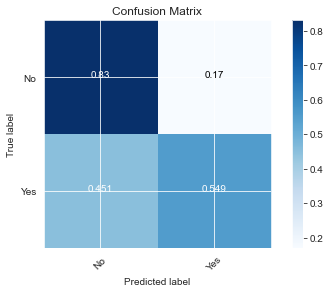

In [226]:
plot_confusion_matrix(model_nb, x_test, y_test, normalize=True)

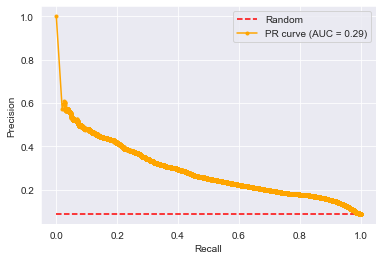

In [227]:
plot_prc(model_nb, x_test, y_test)

In [228]:
encoded_df

,HeartDisease,Smoking,Stroke,PhysicalHealth,DiffWalking,Sex,PhysicalActivity,GenHealth,Asthma,KidneyDisease,...,Diabetic_Yes,Diabetic_Yes (during pregnancy),BMI_Extremely Obese,BMI_Normal,BMI_Obese,BMI_Overweight,BMI_Underweight,SleepTime_High,SleepTime_Low,SleepTime_Normal
0,0,1,0,3.0,0,0,1,3,1,0,...,1,0,0,0,0,0,1,0,1,0
1,0,0,1,0.0,0,0,1,3,0,0,...,0,0,0,1,0,0,0,0,0,1
2,0,1,0,20.0,0,1,1,1,1,0,...,1,0,0,0,0,1,0,0,0,1
3,0,0,0,0.0,0,0,0,2,0,0,...,0,0,0,1,0,0,0,0,1,0
4,0,0,0,28.0,1,0,1,3,0,0,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319790,1,1,0,7.0,1,1,0,1,1,0,...,1,0,0,0,0,1,0,0,1,0
319791,0,1,0,0.0,0,1,1,3,1,0,...,0,0,0,0,0,1,0,0,1,0
319792,0,0,0,0.0,0,0,1,2,0,0,...,0,0,0,1,0,0,0,0,1,0
319793,0,0,0,0.0,0,0,0,2,0,0,...,0,0,0,0,1,0,0,1,0,0


# Conclusion

Random Forest performs the best out of the other models. It gives us a good recall for the minority class, as well as a good AUC for the PR curve. Based on this modeling, I have created a CLI application that will allow the user to input their own data and predict whether they are at risk of heart disease or not.